# Optimization for Machine Learning: Computer Lab 1

### Abdennour Kerboua

## Preprocessing the data

Here, we load the data, standardize it, and set it in the appropriate shape for performing linear regression. You do not need to complete anything in this section; however it is important that you understand what the code is doing. See the pdf instructions for more details.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Loading data
data_matrix_train, COP_train, data_matrix_test, COP_test, names = np.load('data_center_data_matrix.npy', allow_pickle=True)

In [5]:
# centering and normalizing the matrix
matrix_mean = np.mean(data_matrix_train, axis=0)
M = data_matrix_train - matrix_mean

matrix_std = np.std(M, axis=0)
M = M / matrix_std

In [6]:
M.shape

(722, 892)

In [7]:
# Building the corresponding matrices A,b for linear regression
A = np.hstack([M, np.ones((M.shape[0],1)), -(M.T * COP_train[:,3]).T])
b = COP_train[:,3]

# Building the same matrices for the test set
M_test = (data_matrix_test - matrix_mean) / matrix_std
A_test = np.hstack([M_test, np.ones((M_test.shape[0],1)), -(M_test.T * COP_test[:,3]).T])
b_test = COP_test[:,3]

d = A.shape[1]

## Ordinary least squares

We now wish to solve the problem
$$
\min_{w \in \mathbb{R}^d} \frac 12 \|Aw-b\|_2^2
$$

#### 3.1
Si $Aw = b$ alors pour tout $t$, $y(t) = \tilde{x}(t)w_1 + w_0 -y(t) \times \tilde{x}(t)^Tw_2$ et donc $$y(t) \times (1 + \tilde{x}(t)^Tw_2) = \tilde{x}(t)w_1 + w_0$$ et finalement comme $(1 + \tilde{x}(t)^Tw_2) \neq 0$ : $$ y(t) = \frac{\tilde{x}(t)w_1 + w_0}{1 + \tilde{x}(t)^Tw_2} $$

#### 3.2

In [8]:
## Question 3.2: solve with the numpy least squares solver

# COMPLETE HERE
w_least_squares, residuals, rank, s = np.linalg.lstsq(A,b,rcond=False)
print(w_least_squares)

[-0.00927821  0.08309371 -0.03672704 ...  0.01980595 -0.03057174
 -0.01188614]


#### 3.3

In [9]:
## Question 3.3

# COMPLETE HERE
test_error = 1/M_test.shape[0]*np.sum((np.dot(A_test,w_least_squares)-b_test)**2)
print("Test error for least squares solution : ", test_error)

Test error for least squares solution :  780.898479352339


### Adding $\ell_2$ regularization

In order to improve the performance on the test set, we add $\ell_2$ regularization:

$$
\min_{w \in \mathbb{R}^d} \frac 12 \|Aw-b\|_2^2 + \frac \lambda 2 \|w\|_2^2
$$

In [10]:
lambda_l2 = 1e4

#### 3.4

Si $f_1(w) = \frac{1}{2}||Aw - b||^2 + \frac{\lambda}{2} ||w||^2$ alors : $$ \nabla f_1(w) =\frac{1}{2} \times 2 \times A^T (Aw -b) + \frac{\lambda}{2} \times 2 \times w = A^T(Aw -b) + \lambda w = (A^TA + \lambda I_n)w - A^Tb  $$ Il vient donc pour la hessienne : $$ \nabla^2 f_1(w) = A^TA + \lambda I_n $$ qui est symétrique définie positive ssi les valeurs propres de $A^TA$ sont plus grandes que $-\lambda$. Or $A^TA$ est une matrice symétrique semi-définie positive et donc de valeur propres positives ou nulles et donc plus grandes que $-\lambda$. Finalement, $A^TA + \lambda I_n$ est semi-définie positive et donc $f_1$ est convexe.

#### 3.5

In [11]:
# Question 3.5
def f(w):
    return 1/2*(np.sum((np.dot(A,w)-b)**2)) + lambda_l2/2*np.sum(w**2)

def grad_f(w):
    S = np.dot(A.T,A)
    return np.dot(S + lambda_l2*np.eye(S.shape[0]),w) - np.dot(A.T,b)

def gradient_descent(func, w0, gamma, max_iter):
    w = w0.copy()

    f_values = []
    gradient_norms = []

    for t in range(max_iter):
        # COMPLETE HERE
        w = w - gamma*grad_f(w)

        f_values.append(f(w))
        gradient_norms.append(np.linalg.norm(grad_f(w)))

    return w, f_values, gradient_norms

For finding the appropriate step size range, we need to estimate the Lipschitz constant of the gradient.

#### 3.5 (*suite : Step size*)

Il faut prendre le maximum des valeurs propres de $A^TA + \lambda I_n$ (hessienne de $f$). Or les valeurs propres de cette matrice sont simplement celles de $A^TA$ augmentées de $\lambda$. Il suffit alors de prendre $L = \mu_{max}(A^TA) + \lambda$.

In [12]:
# COMPLETE HERE
L = np.max(np.linalg.eigvals(A.T@A)) + lambda_l2

(3502543.105358826+0j)


In [28]:
# COMPLETE HERE
w0 = np.zeros(w_least_squares.shape)
step_size = 1/L
max_iter = 2350

w_GD, f_values_GD, gradient_norms_GD = gradient_descent(f, w0, step_size, max_iter)
print(gradient_norms_GD[-12])
print(gradient_norms_GD[-11])

1.0020255321860536
0.9988674836022964


#### 3.5 (nombre d'itérations nécesssaires) 
Il faut donc **2340** itérations pour avoir $||\nabla f(w)|| \leq 1$.

We now compute the evolution of function values and gradient norm.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Function values')

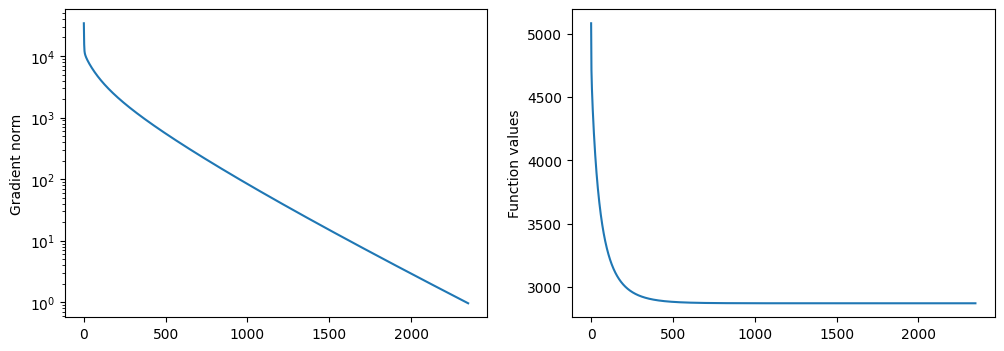

In [29]:
# let us plot the result
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(gradient_norms_GD)
axes[0].semilogy()
axes[0].set_ylabel("Gradient norm")

axes[1].plot(f_values_GD)
axes[1].set_ylabel("Function values")

#### 3.6

In [31]:
# Question 3.6

test_error_l2 = 1/M_test.shape[0]*np.real(np.sum((np.dot(A_test,w_GD)-b_test)**2))
print("Test error for l2 penalized solution : ", test_error_l2)

Test error for l2 penalized solution :  61.52268036010242


What do you observe ?

On obtient une erreur quadratique moyenne bien meilleure avec la régularisation $\ell^2$.

For a faster algorithm, we could implement accelerated gradient descent.

#### 3.7

In [34]:
# Question 3.7 (optional)

def accelerated_gradient_descent(func, w0, gamma, max_iter):
    w = w0.copy()
    y = []
    f_values = []
    gradient_norms = []

    for t in range(max_iter):
        y.append(w - gamma*grad_f(w))
        if t>0:
            w = y[-1] + (t+1)/(t+4)*(y[-1]-y[-2])
        f_values.append(f(w))
        gradient_norms.append(np.linalg.norm(grad_f(w)))

    return w, f_values, gradient_norms

In [60]:
# COMPLETE HERE
w0 = np.zeros(w_GD.shape)
step_size = 1/L
max_iter = 2350

w_AGD, f_values_AGD, gradient_norms_AGD = accelerated_gradient_descent(f, w0, step_size, max_iter)

In [61]:
print(gradient_norms_AGD[-1270])
print(gradient_norms_AGD[-1269])

1.001431401820898
0.9949134657592478


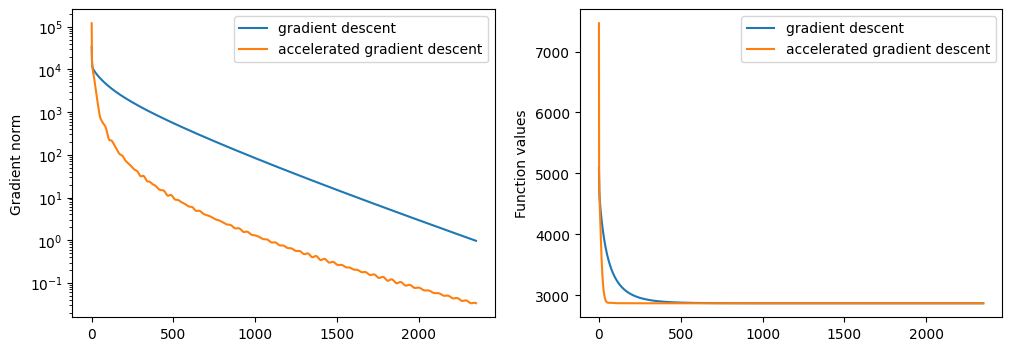

In [62]:
# let us plot the result
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(gradient_norms_GD, label = "gradient descent")
axes[0].plot(gradient_norms_AGD, label = "accelerated gradient descent")
axes[0].semilogy()
axes[0].set_ylabel("Gradient norm")
axes[0].legend()

axes[1].plot(f_values_GD, label = "gradient descent")
axes[1].plot(f_values_AGD, label = "accelerated gradient descent")
axes[1].set_ylabel("Function values")
axes[1].legend()

What do you observe regarding the convergence speed ?

Il aura donc fallut **1081** itérations pour vérifier $\nabla f(w)\leq 1$. Soit **1259** itérations de moins que pour la descente classique. De plus, on remarque sur le graphique que l'algorithme converge beaucoup plus rapidement vers le minimum et la norme du gradient décroît beaucoup plus nettement et rapidement. Cependant, la variation de la norme du gradient dans l'algorithme de descente accélérée est visiblement non-monotone. Autrement dit, la norme du gradient n'est pas toujours plus petite d'une itération à l'autre.

## 4. Adding $\ell_1$ regularization (Lasso)

We now solve

$$
\min_{w \in \mathbb{R}^d} \frac 12 \|Aw-b\|_2^2 + \lambda \|w\|_1
$$

#### 4.1

La fonction $F_2(w) = \frac{1}{2} ||Aw - b||^2_2 + \lambda ||w||_1$ à minimiser peut s'écrire : $F_2(w) = f_2(w) + g_2(w)$ avec $f_2(w) = \frac{1}{2}||Aw - b||_2^2$ convexe et différentiable et $g_2(w) = \lambda ||w||_1$ facile à calculer.

De plus $[\operatorname{prox}_{g_2}(x)]_i = \left\{\begin{array}{ll} x_i + \lambda \gamma & \text{ si } x_i \leq - \lambda \gamma \\ x_i - \lambda \gamma & \text{ si } x_i \geq \lambda \gamma \\ 0 & \text{si } x_i \leq |\lambda \gamma| \end{array}\right.$ et $\nabla f_2(x) = A^T(Ax - b)$.

#### 4.2

In [63]:
lambda_l1 = 1e3

## Question 4.2
def prox_l1(x, mu = 1.):
    """compute the proximal operator of mu * |x|_1
    """
    return np.sign(x) * np.maximum(np.abs(x) - mu, 0)

def grad_f_2(w):
    return A.T@(A@w - b)

def proximal_gradient_descent(func, w0, gamma, max_iter):
    w = w0.copy()
    f_values = []
    grad_values = []
    
    for t in range(max_iter):
        # Compute the gradient of the smooth part
        grad = grad_f_2(w)
        # Gradient descent step
        w = w - gamma * grad
        # Apply the proximal operator (to handle the non-smooth part)
        w = prox_l1(w, lambda_l1 * gamma)
        # Store the objective function value
        f_values.append(func(w))
        grad_values.append(grad_f_2(w))
    return w, f_values, grad_values


In [68]:
# COMPLETE HERE
w0 = np.zeros(w_AGD.shape)
step_size = 1/L
max_iter = 2350

w_PGD, f_values_PGD, gradient_norms_PGD = proximal_gradient_descent(f, w0, step_size, max_iter)

#### 4.3

In [69]:
# Question 4.3

test_error_l1 = 1/M_test.shape[0]*np.real(np.sum((np.dot(A_test,w_PGD)-b_test)**2))
print("Test error for l1 penalized solution : ", test_error_l1)

Test error for l1 penalized solution :  4.232305515394703


Compare with the previous test errors. What do you observe?

Le résultat est encore meilleur sur le set de test avec la régularisation $\ell^1$.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


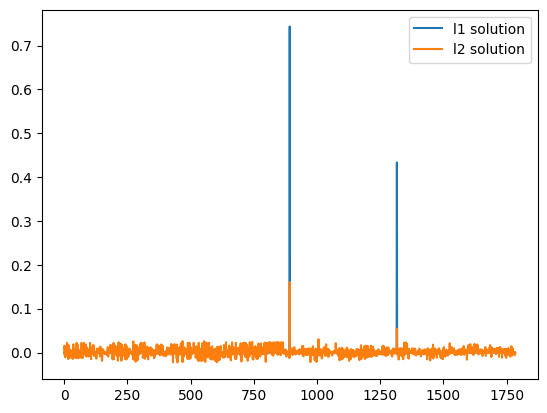

In [70]:
# Let us examine the solution
plt.plot(w_PGD, label = "l1 solution")
plt.plot(w_GD, label = "l2 solution")
plt.legend()

#### 4.4

In [67]:
# Question 4.4
def proximal_gradient_descent_linesearch(func, w0, gamma, max_iter):
    w = w0.copy()
    f_values = []
    grad_values = []
    beta = 1/2

    for t in range(max_iter):
        grad = grad_f_2(w)
        gamma_t = gamma
        while True:
            w_new = prox_l1(w - gamma_t * grad, gamma_t*lambda_l1)
            if func(w_new) <= (func(w) 
                               + np.dot(grad, w_new - w) 
                               + (1 / (2 * gamma_t)) * np.linalg.norm(w_new - w)**2):
                break 
            
            gamma_t *= beta
        w = w_new
        gamma = gamma_t*2
        f_values.append(func(w))
        grad_values.append(grad_f_2(w))
    return w, f_values, grad_values

## Tuning the penalization parameter

How to find the best solution among all those that were comptued? How to choose the penalization parameter $\lambda$?

In [ ]:
# Your method here...